In [1]:
# Data import and cleaning.

import numpy as np
import pandas as pd

# Just a maybe-useful but messy function for seeing what's going on in the data table:
def describe_data(data):
    for col in data.columns:
        valc=data[col].value_counts()
        print('--------------')
        print('* ',col,len(valc),'values.')
        if len(valc)<10:
            print(valc)
        print(data[col].isnull().sum(),'NaNs')

# Performs one-hot encoding on all non-numerical variables and also drops columns containing missing data:
def one_hot(data):
    bad_columns=[]
    for col in data.columns:
        if data[col].dtype=='object':
            bad_columns.append(col)
    return pd.get_dummies(data.dropna(),columns=bad_columns,drop_first=True)
        
raw_data=pd.read_csv("anemia_neater.csv")

# Replace mother's age group with the lowest boundary of respective age group (a useful numerical value):
clean_data=raw_data.assign(mothers_age_group = raw_data['mothers_age_group'].str[:2].astype(int),
                          child_tested = 1 - raw_data['childs_hemoglobin'].isna())

# Binarise the anemia dignosis columns
clean_data.replace({'Not anemic':0,'Mild':1,'Moderate':1,'Severe':1},inplace=True)

# A few "Don't know" values in the table; interpret as missing data:
clean_data.replace("Don't know",np.NaN,inplace=True)
#describe_data(clean_data)

# Just tables for subsequent analyses:
testing_data=one_hot(clean_data.drop(columns=['mothers_anemia','mothers_hemoglobin','childs_hemoglobin','childs_anemia']))
anemia_data=one_hot(clean_data.drop(columns=['mothers_hemoglobin','childs_hemoglobin','child_tested']))
regression_data=one_hot(clean_data.drop(columns=['mothers_anemia','mothers_hemoglobin','childs_anemia','child_tested']))


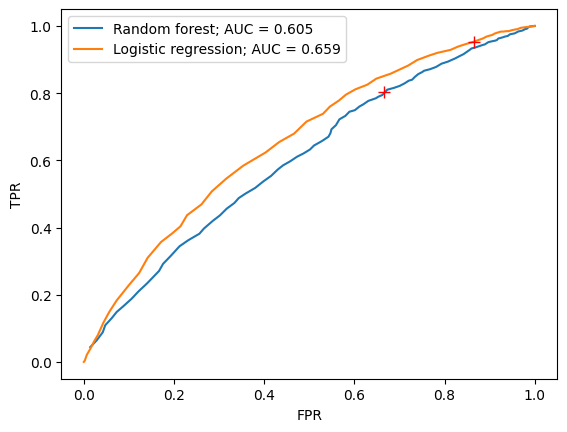

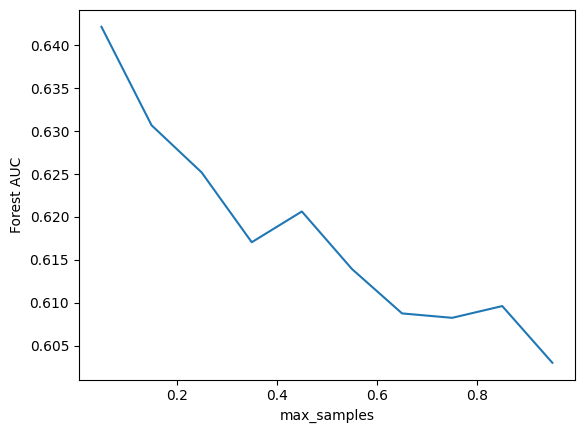

In [4]:
# Classifiers.

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Returns a confusion matrix from given predicted probabilities vs actual labels and a threshold value.
def calculate_confusion(y_pred,y_test,threshold):
    df=pd.DataFrame({'p':y_pred, 'y':y_test.reset_index(drop=True)})
    df['predicted'] = (df['p']>=threshold)
    tots=len(df['predicted'])
    fp=(df['predicted']>df['y']).sum()
    fn=(df['predicted']<df['y']).sum()
    tp=df['predicted'].sum() - fp;
    tn = tots - fp - fn - tp;
    return ([[tp, fn], [fp, tn]])

# Calculates an approximate ROC curve for given classifier model, and returns its AUC. 
# If drawPicture=True (default) then also draws the curve, otherwise simply does the calculations for AUC.
# If showCutoff in given then draws a cross on the curve at that point.
# plt.show() is not called, so subsequent drawings go to the same picture (useful for comparing models).
def analyse_ROC(model,X_test,y_test,title='',steps=100,drawPicture=True,showCutoff=None):
    probabilities=pd.DataFrame(model.predict_proba(X_test))
    p=0
    dp=1/steps
    tpr_array=[]
    fpr_array=[]
    while p<=1:
        confusion=calculate_confusion(probabilities[1],y_test,p)
        tpr_array.append(confusion[0][0]/sum(confusion[0]))
        fpr_array.append(confusion[1][0]/sum(confusion[1]))
        p+=dp
    tpr_array=np.array(tpr_array)
    fpr_array=np.array(fpr_array)
    AUC=0
    for i in range(1,len(tpr_array)):
        AUC += (tpr_array[i-1]+tpr_array[i])/2 * (fpr_array[i-1]-fpr_array[i])
    # Add the area of the last corner (the calculated curve may not reach the (0,0) point):
    AUC += tpr_array[-1]/2 * fpr_array[-1]
    
    if drawPicture:
        plt.plot(fpr_array,tpr_array,label="{title}; AUC = {AUC:.3f}".format(title=title,AUC=AUC))
        if not (showCutoff is None):
            confusion=calculate_confusion(probabilities[1],y_test,showCutoff)
            plt.plot(confusion[1][0]/sum(confusion[1]),confusion[0][0]/sum(confusion[0]),'r+',markersize=8)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    return AUC

# Still needs balancing but let's start somewhere:

#X_train,X_test,y_train,y_test = train_test_split(testing_data.drop(columns="child_tested"),
#                                                 testing_data["child_tested"],
#                                                 test_size=0.3)

X_train,X_test,y_train,y_test = train_test_split(anemia_data.drop(columns="childs_anemia"),
                                                 anemia_data["childs_anemia"],
                                                 test_size=0.3)


forestModel=RandomForestClassifier(n_estimators=100,max_samples=0.99,max_depth=None).fit(X_train,y_train)
analyse_ROC(forestModel,X_test,y_test,title="Random forest",showCutoff=0.5)

logModel=LogisticRegression(max_iter=1000).fit(X_train,y_train)
analyse_ROC(logModel,X_test,y_test,title="Logistic regression",showCutoff=0.5)

plt.legend()
plt.show()

max_s_array=[]
AUC_array=[]
max_s=0.05
while max_s<1.0:
    max_s_array.append(max_s)
    AUC_array.append(analyse_ROC(RandomForestClassifier(n_estimators=100,max_samples=max_s,max_depth=None).fit(X_train,y_train),
                                 X_test,y_test,drawPicture=False))
    max_s+=0.1
plt.plot(max_s_array,AUC_array)
plt.xlabel('max_samples')
plt.ylabel('Forest AUC')
plt.show()

mothers_age_group: 0.0744
mothers_births_5y: -0.4350
mothers_age_at_1st_birth: 0.1825
mothers_residence_Urban: 0.8634
mothers_education_No education: -1.1735
mothers_education_Primary: -0.0000
mothers_education_Secondary: -0.0000
mothers_wealth_index_Poorer: -1.9020
mothers_wealth_index_Poorest: -4.2886
mothers_wealth_index_Richer: 0.0000
mothers_wealth_index_Richest: 3.5719
mosquito_net_Yes: -0.0000
mother_smokes_Yes: 0.0000
mothers_marital_Married: 0.0000
mothers_partner_Staying elsewhere: 0.0000
fever_last_2_weeks_Yes: -3.8329
iron_pills_Yes: 0.0000


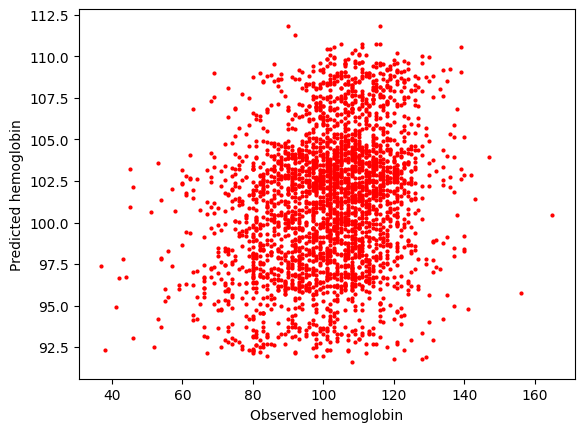

R2 = 0.062


In [3]:
# Regressions

from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.model_selection import train_test_split

# Just sum of squared deviations from mean for given array y
def SumSqr(y):
    y_mean=y.mean()
    return ((y-y_mean)**2).sum()

# Returns R-squared for given model - how much of the ebserved variance of y_obs it explains
def R2Model(model,X_obs,y_obs):
    return 1 - SumSqr(y_obs-model.predict(X_obs))/SumSqr(y_obs)

# Draws observed vs predicted scatterplot for given model; returns R2 as above
def ShowModel(model,X_obs,y_obs,obs_lab='Observed',pred_lab='Predicted'):
    y_pred=model.predict(X_obs)
    plt.plot(y_obs,y_pred,'ro',markersize=2)
    plt.xlabel(obs_lab)
    plt.ylabel(pred_lab)
    plt.show()
    return 1 - SumSqr(y_obs-y_pred)/SumSqr(y_obs)    

X_train, X_test, y_train, y_test = train_test_split(regression_data.drop(columns='childs_hemoglobin'),
                                                    regression_data['childs_hemoglobin'],test_size=0.3)

# Make some regression model and draw the resulting observed vs predicted relation:
model=Lasso(alpha=0.1).fit(X_train,y_train)
#model=LinearRegression().fit(X_train,y_train)

# Print out the model's corfs:
for i in range(0,len(model.coef_)):
    print('%s: %0.4f' % (model.feature_names_in_[i],model.coef_[i]))
    
# Show observed vs predicted graph and print R2:
print('R2 = %0.3f' % ShowModel(model,X_test,y_test,obs_lab="Observed hemoglobin",pred_lab="Predicted hemoglobin"))
